In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil

In [9]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(fname="flower_photos.tgz", origin=_URL, extract=True)
zip_dir_base = os.path.dirname(zip_file)

In [4]:
# read cats and dogs data
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", origin=url, extract=True)

In [5]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/Users/Oliver/.keras/datasets
/Users/Oliver/.keras/datasets/cats_and_dogs_filtered
/Users/Oliver/.keras/datasets/cats_and_dogs_filtered/train
/Users/Oliver/.keras/datasets/cats_and_dogs_filtered/train/dogs
/Users/Oliver/.keras/datasets/cats_and_dogs_filtered/train/cats
/Users/Oliver/.keras/datasets/cats_and_dogs_filtered/validation
/Users/Oliver/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/Users/Oliver/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [7]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered') # parent directory
train_dir = os.path.join(base_dir, 'train') # directory with all training data
val_dir = os.path.join(base_dir, 'validation') # directory with all validation data

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
val_cats_dir = os.path.join(val_dir, 'cats')  # directory with our validation cat pictures
val_dogs_dir = os.path.join(val_dir, 'dogs')  # directory with our validation dog pictures

In [8]:
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(val_cats_dir))
num_dogs_val = len(os.listdir(val_dogs_dir))

print(f"Number of cat pictures for training {num_cats_train}")
print(f"Number of dog pictures for training {num_dogs_train}")
print(f"Number of cat pictures for validation {num_cats_val}")
print(f"Number of dog pictures for validation {num_dogs_val}")

Number of cat pictures for training 1000
Number of dog pictures for training 1000
Number of cat pictures for validation 500
Number of dog pictures for validation 500


In [9]:
# Change images to floating point values between 0 and 1 and applying image augmentation (rotate, flip, zoom)
train_image_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=45,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.5,
                                     horizontal_flip=True)

# Training data reshaped into 150 x 150 and pulled from disk in batches of 100
train_generator = train_image_generator.flow_from_directory(directory=train_dir,
                                                            target_size=(150, 150),
                                                            batch_size=100,
                                                            shuffle=True,
                                                            class_mode='binary')

# Seperate image generator for validation data without augmentation
val_image_generator = ImageDataGenerator(rescale=1./255)
val_generator = val_image_generator.flow_from_directory(directory=val_dir,
                                                   target_size=(150, 150),
                                                   batch_size=100,
                                                   shuffle=False,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


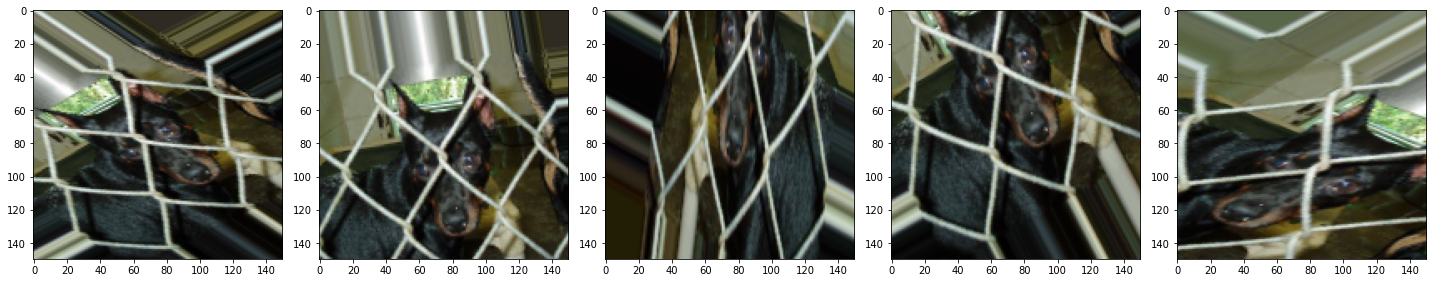

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# example of image augmentation
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 = 128 * 3 for R, G & B
    tf.keras.layers.Dense(512, activation="relu"),
    
    tf.keras.layers.Dense(2, activation="softmax")])

2021-12-06 13:26:34.669083: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
# Batches come from a generator so we use .fit_generator()
epochs = 10
history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil((num_cats_train+num_dogs_train)/float(100))),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=int(np.ceil((num_cats_val+num_dogs_val)/float(100)))
)

/Users/Oliver/Code/.bioi/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10


/Users/Oliver/Code/.bioi/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 60s 3s/step - loss: 0.7191 - accuracy: 0.4945 - val_loss: 0.6918 - val_accuracy: 0.5240
Epoch 2/10
20/20 [==============================] - 59s 3s/step - loss: 0.6904 - accuracy: 0.5295 - val_loss: 0.6761 - val_accuracy: 0.6040
Epoch 3/10
20/20 [==============================] - 53s 3s/step - loss: 0.6893 - accuracy: 0.5600 - val_loss: 0.7105 - val_accuracy: 0.5020
Epoch 4/10
20/20 [==============================] - 63s 3s/step - loss: 0.6906 - accuracy: 0.5185 - val_loss: 0.6778 - val_accuracy: 0.5960
Epoch 5/10
20/20 [==============================] - 52s 3s/step - loss: 0.6739 - accuracy: 0.5875 - val_loss: 0.6505 - val_accuracy: 0.6330
Epoch 6/10
20/20 [==============================] - 56s 3s/step - loss: 0.6709 - accuracy: 0.5735 - val_loss: 0.6651 - val_accuracy: 0.6400
Epoch 7/10
20/20 [==============================] - 51s 3s/step - loss: 0.6733 - accuracy: 0.5770 - val_loss: 0.6708 - val_accuracy: 0.6260
Epoch 8/10
20/20 [=============

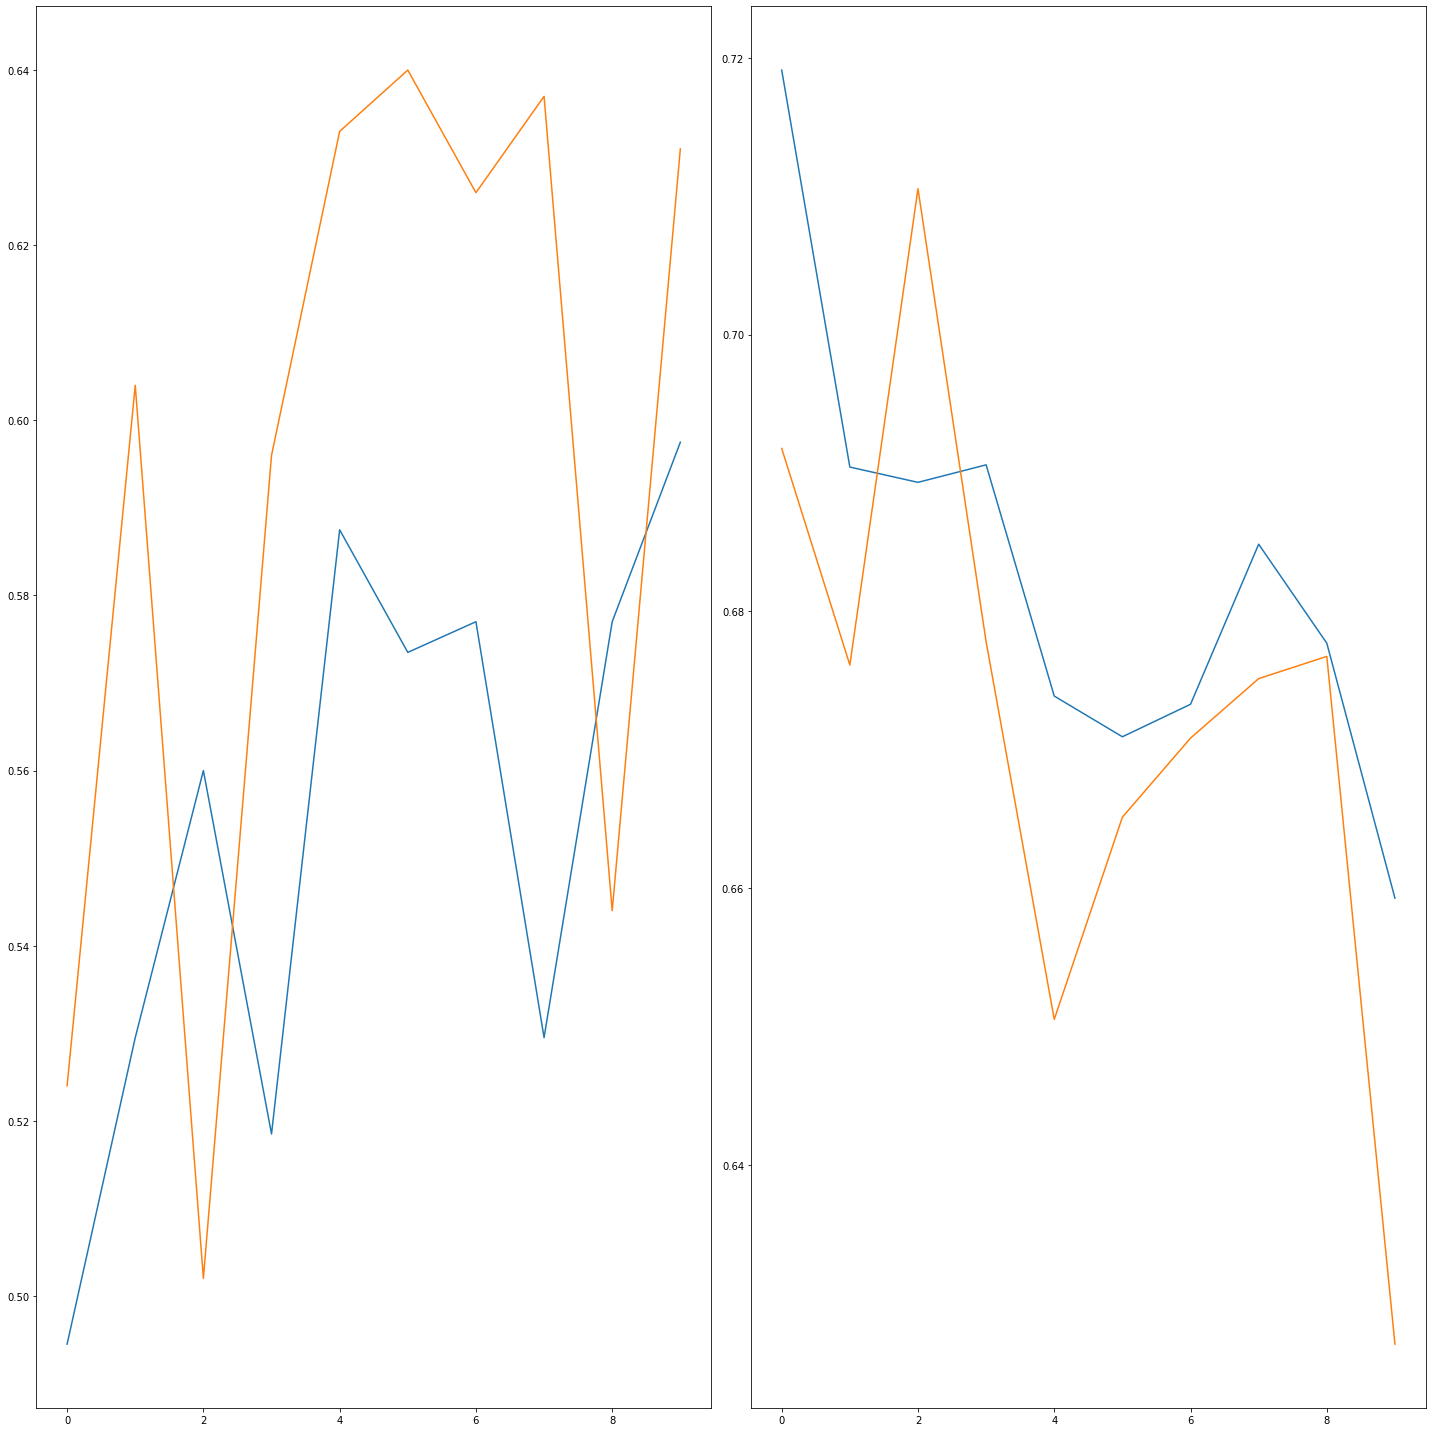

In [22]:
# model is struggling from overfitting due to epoch limitations ... so slow ...
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].plot(history.history["accuracy"])
ax[0].plot(history.history["val_accuracy"])
ax[1].plot(history.history["loss"])
ax[1].plot(history.history["val_loss"])
plt.tight_layout()
plt.show()